In [1]:
import torch
from diffusers import StableDiffusionPipeline
from consistencydecoder import ConsistencyDecoder, save_image, load_image, _extract_into_tensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from modules.models.decoding.openai_decoder import DiffusionDecoder


/home/pg51242/Desktop/text2img-gen/text2img_dm/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def transf(image):
    image = image[0].cpu().numpy()
    image = (image + 1.0) * 127.5
    image = image.clip(0, 255).astype(np.uint8)
    image = Image.fromarray(image.transpose(1, 2, 0))

    return image

# Encode an image into a latent

In [3]:
# cdd = ConsistencyDecoder(device="cuda:0") # Model size: 2.49 GB
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, device="cuda:0"
)
pipe.vae.cuda()

image = load_image("people.jpg", size=(256, 256), center_crop=True)
latent = pipe.vae.encode(image.half().cuda()).latent_dist.mean
image.shape, latent.shape

Keyword arguments {'device': 'cuda:0'} are not expected by StableDiffusionPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]


(torch.Size([1, 3, 256, 256]), torch.Size([1, 4, 32, 32]))

# Decode latent with Consistency Decoder from OpenAI

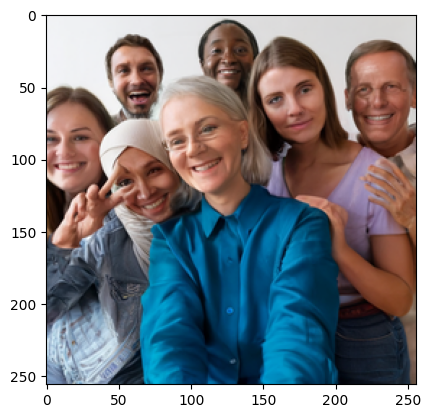

In [4]:
decoder_consistency = ConsistencyDecoder(device="cuda:0") # Model size: 2.49 GB
sample_consistency = decoder_consistency(latent)
plt.imshow(transf(sample_consistency))

# Decode latent with replicated Consistency Decoder

In [10]:
#del decoder_consistency
decoder_consistency = ConsistencyDecoder(device="cpu") # Model size: 2.49 GB

In [6]:
# Load replicated model
cdd = DiffusionDecoder(320)
cdd.load_state_dict(torch.load("cdd_custom.pt"))
cdd = cdd.cuda()
cdd

DiffusionDecoder(
  (input): Conv2d(7, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_embed): Sequential(
    (0): Linear(in_features=320, out_features=1280, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0-2): 3 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1280, out_features=640, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [11]:
features = latent
schedule=[1.0, 0.5, 0.2] # Timestep sampling schedule
# Rescale the latents
features = decoder_consistency.ldm_transform_latent(features)

# Get the n_distilled timesteps being used for full sampling
ts = decoder_consistency.round_timesteps(
    torch.arange(0, 1024),
    1024,
    decoder_consistency.n_distilled_steps,
    truncate_start=False,
)
    
shape = (
    features.size(0),
    3,
    8 * features.size(2),
    8 * features.size(3),
)

x_start = torch.zeros(shape, device=features.device, dtype=features.dtype) # Initial input
schedule_timesteps = [int((1024 - 1) * s) for s in schedule]
with torch.cuda.amp.autocast() and torch.no_grad():
    for i in schedule_timesteps:
        t = ts[i].item() # Current timestep
        t_ = torch.tensor([t] * features.shape[0]).to("cuda")
        # Sampler
        noise = torch.randn_like(x_start)
        x_start = (
            _extract_into_tensor(decoder_consistency.sqrt_alphas_cumprod.to("cuda"), t_, x_start.shape)
            * x_start
            + _extract_into_tensor(
                decoder_consistency.sqrt_one_minus_alphas_cumprod.to("cuda"), t_, x_start.shape
            )
            * noise
        )
        print(_extract_into_tensor(decoder_consistency.sqrt_alphas_cumprod.to("cuda"), t_, x_start.shape))
        
        # Denoiser
        c_in = _extract_into_tensor(decoder_consistency.c_in.to("cuda"), t_, x_start.shape)
        model_output = cdd(c_in.cuda() * x_start.cuda(), t_.cuda(), context=features.cuda())
        # B, C = x_start.shape[:2]
        # model_output, _ = torch.split(model_output, C, dim=1)
        pred_xstart = (
            _extract_into_tensor(decoder_consistency.c_out.to("cuda"), t_, x_start.shape) * model_output
            + _extract_into_tensor(decoder_consistency.c_skip.to("cuda"), t_, x_start.shape) * x_start
        ).clamp(-1, 1)
        x_start = pred_xstart

tensor([[[[0.0228]]]], device='cuda:0')
tensor([[[[0.7017]]]], device='cuda:0')
tensor([[[[0.9459]]]], device='cuda:0')


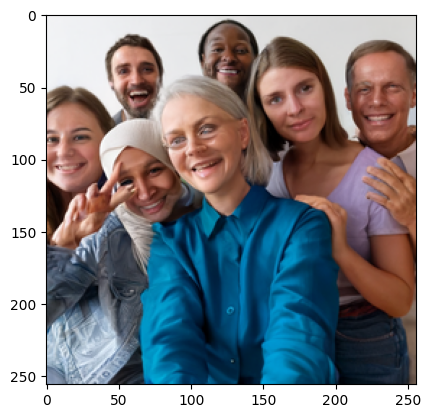

In [15]:
plt.imshow(transf(x_start.cpu()))

In [8]:
del cdd, decoder_consistency
torch.cuda.empty_cache()
decoder_consistency = ConsistencyDecoder(device="cuda:0") # Model size: 2.49 GB


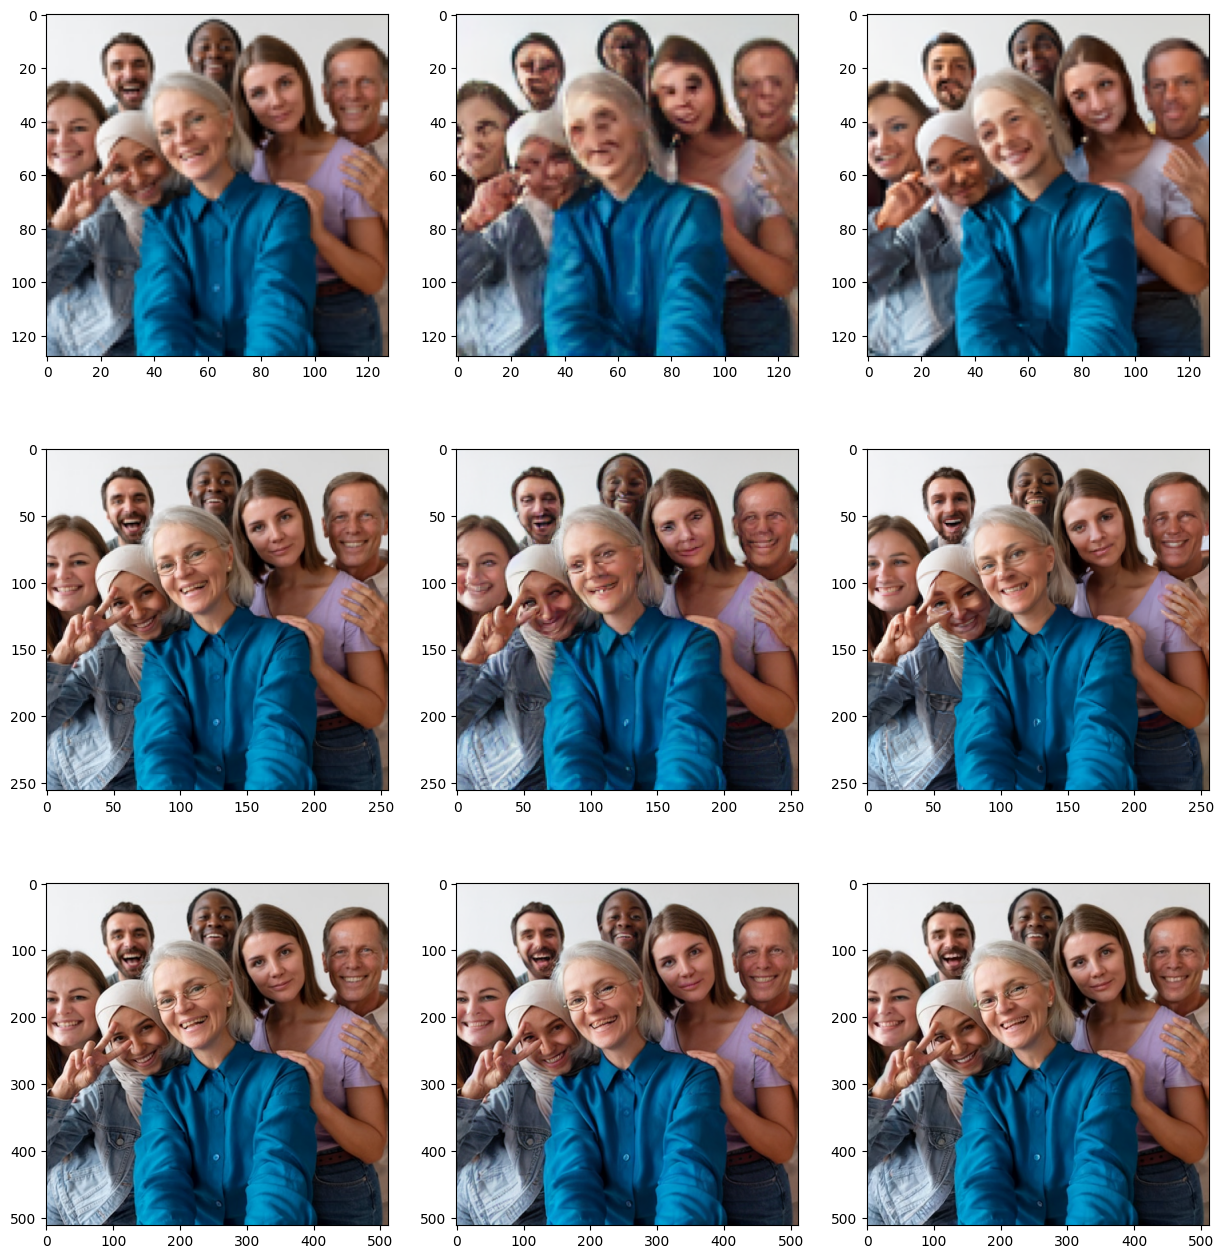

In [12]:
resolutions = [128, 256, 512]

fig = plt.figure(figsize = (15,16))

diffs_gan = []
diffs_cons = []
for i in range(len(resolutions)):
    res = resolutions[i]
    image = load_image("people.jpg", size=(res, res), center_crop=True)
    latent = pipe.vae.encode(image.half().cuda()).latent_dist.mean
    # decode with gan
    sample_gan = pipe.vae.decode(latent).sample.detach()

    # decode with vae
    sample_consistency = decoder_consistency(latent)

    ax1 = fig.add_subplot(len(resolutions), 3, (i*3) + 1)
    plt.imshow(transf(image))
    ax2 = fig.add_subplot(len(resolutions), 3, (i*3) + 2)
    plt.imshow(transf(sample_gan))
    ax3 = fig.add_subplot(len(resolutions), 3, (i*3) + 3)
    plt.imshow(transf(sample_consistency))

    del image, sample_gan, sample_consistency, latent

# Experiment the CDD in the normal diffusion engine

In [4]:
del pipe

In [34]:
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

model_config = OmegaConf.load("configs/models/consistency_diffusion_decoder.yaml")
diffusion_decoder = instantiate_from_config(model_config.model)
# Load replicated model
cdd = DiffusionDecoder(320)
cdd.load_state_dict(torch.load("cdd_custom.pt"))
cdd = cdd.cuda()
diffusion_decoder.model.diffusion_model = cdd
sampler = instantiate_from_config(model_config.model.params.sampler_config)


HELLOP
Initialized embedder #0: IdentityEncoder with 0 params. Trainable: True


In [7]:
def ldm_transform_latent(z, extra_scale_factor=1):
    channel_means = [0.38862467, 0.02253063, 0.07381133, -0.0171294]
    channel_stds = [0.9654121, 1.0440036, 0.76147926, 0.77022034]

    if len(z.shape) != 4:
        raise ValueError()

    z = z * 0.18215
    channels = [z[:, i] for i in range(z.shape[1])]

    channels = [
        extra_scale_factor * (c - channel_means[i]) / channel_stds[i]
        for i, c in enumerate(channels)
    ]
    return torch.stack(channels, dim=1)

tensor([1.], device='cuda:0')
SCHEDULE TIMESTEPS: [1023, 511]
=> 1023 tensor(20778.1562, device='cuda:0')
STEP: 1023
torch.Size([1024])
torch.Size([1, 1, 1, 1]) tensor([[[[4.8127e-05]]]], device='cuda:0')
=> 511 tensor(1.0124, device='cuda:0')
STEP: 511
torch.Size([1024])
torch.Size([1, 1, 1, 1]) tensor([[[[0.7027]]]], device='cuda:0')


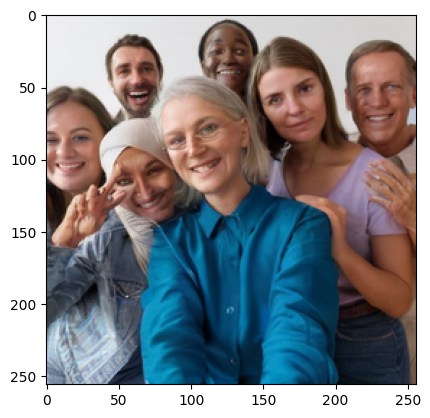

In [36]:
from generate_new_decoder import generate_from_decoder

features = ldm_transform_latent(latent)
diffusion_decoder = diffusion_decoder.cuda()

samples = generate_from_decoder(diffusion_decoder, sampler, features.to("cuda"), img_dims=256).to("cuda")
plt.imshow(samples.cpu().numpy()[0].transpose(1, 2, 0))